In [130]:
from importlib import reload
import torch
import torch.nn.functional as F
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score

import data
reload(data)
from data import AmlsimDataset

import modules
reload(modules)
from modules import GCN, GCN_GNNExplainer, GAT_GNNExplainer
from modules import GraphSAGE
from torch_geometric.data import DataLoader
import torch.optim as optim

import torch_geometric as pytg


In [131]:
# Set device to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [132]:
# Load data
traindata = AmlsimDataset(node_file='data/simulation2/swedbank/train/nodes.csv', edge_file='data/simulation2/swedbank/train/edges.csv', node_features=True, node_labels=True).get_data()
testdata = AmlsimDataset(node_file='data/simulation2/swedbank/test/nodes.csv', edge_file='data/simulation2/swedbank/test/edges.csv', node_features=True, node_labels=True).get_data()
traindata = traindata.to(device)
testdata = testdata.to(device)

# # Convert label tensors to one-hot encoded form
# traindata.y = F.one_hot(traindata.y, num_classes=2)
# testdata.y = F.one_hot(testdata.y, num_classes=2)

In [133]:
# Normalize data
mean = traindata.x.mean(dim=0, keepdim=True)
std = traindata.x.std(dim=0, keepdim=True)
traindata.x = (traindata.x - mean) / std
testdata.x = (testdata.x - mean) / std

In [134]:
# Instantiate model
input_dim = 10
hidden_dim = 16
output_dim = 2
n_layers = 3
dropout = 0.3
#model = GCN_GNNExplainer(input_dim, hidden_dim, output_dim, n_layers, dropout)
model = GAT_GNNExplainer(input_dim, hidden_dim, output_dim, n_layers, dropout)
model.to(device)

GAT_GNNExplainer(
  (conv1): GATConv(10, 16, heads=3)
  (conv2): GATConv(48, 16, heads=3)
  (conv3): GATConv(48, 2, heads=1)
  (softmax): Softmax(dim=1)
)

In [135]:
print(traindata.edge_index.shape)
traindata = pytg.transforms.ToUndirected()(traindata)
testdata = pytg.transforms.ToUndirected()(testdata)
print(traindata.edge_index.shape)

torch.Size([2, 1194])
torch.Size([2, 2388])


In [136]:
# optimizer
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [137]:
# loss function
weight = torch.tensor([1, 5.5], dtype=torch.float32).to(device)
#criterion = torch.nn.CrossEntropyLoss(weight = weight)
criterion = torch.nn.NLLLoss(weight = weight)

In [138]:
for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    out = model.forward(traindata.x, traindata.edge_index)
    loss = criterion(out, traindata.y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            out = model.forward(testdata.x, testdata.edge_index)
            loss = criterion(out, testdata.y)
            precision = precision_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
            recall = recall_score(testdata.y.cpu().numpy(), out.cpu().numpy().argmax(axis=1), zero_division=0)
            print(f'epoch: {epoch + 1}, loss: {loss:.4f}, precision: {precision:.4f}, recall: {recall:.4f}')

epoch: 10, loss: -0.4954, precision: 0.4625, recall: 0.2229
epoch: 20, loss: -0.4938, precision: 0.5055, recall: 0.2771
epoch: 30, loss: -0.4964, precision: 0.5149, recall: 0.3133
epoch: 40, loss: -0.5005, precision: 0.5000, recall: 0.3313
epoch: 50, loss: -0.5064, precision: 0.5083, recall: 0.3675
epoch: 60, loss: -0.5114, precision: 0.4766, recall: 0.3675
epoch: 70, loss: -0.5154, precision: 0.4769, recall: 0.3735
epoch: 80, loss: -0.5172, precision: 0.4737, recall: 0.3795
epoch: 90, loss: -0.5173, precision: 0.4737, recall: 0.3795
epoch: 100, loss: -0.5158, precision: 0.4701, recall: 0.3795
epoch: 110, loss: -0.5135, precision: 0.4737, recall: 0.3795
epoch: 120, loss: -0.5096, precision: 0.4773, recall: 0.3795
epoch: 130, loss: -0.5060, precision: 0.4809, recall: 0.3795
epoch: 140, loss: -0.5022, precision: 0.4729, recall: 0.3675
epoch: 150, loss: -0.4976, precision: 0.4597, recall: 0.3434
epoch: 160, loss: -0.4938, precision: 0.4667, recall: 0.3373
epoch: 170, loss: -0.4893, precis

In [129]:
from sklearn.metrics import confusion_matrix
import numpy as np

model.eval()
with torch.no_grad():
    out = model.forward(testdata.x, testdata.edge_index)
    y_pred = out.cpu().numpy().argmax(axis=1)
    y_true = testdata.y.cpu().numpy()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

[[352  48]
 [123  43]]


In [108]:
from torch_geometric.data import Data
from torch_geometric.explain import Explainer, GNNExplainer

data = testdata  # A homogeneous graph data object.

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='probs',  # Model returns log probabilities.
    ),
)

# Generate explanation for the node at index `10`:
node_to_explain = 318
explanation = explainer(data.x, data.edge_index, index=node_to_explain)
print(explanation.edge_mask)
print(explanation.node_mask)

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0777,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.9061, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

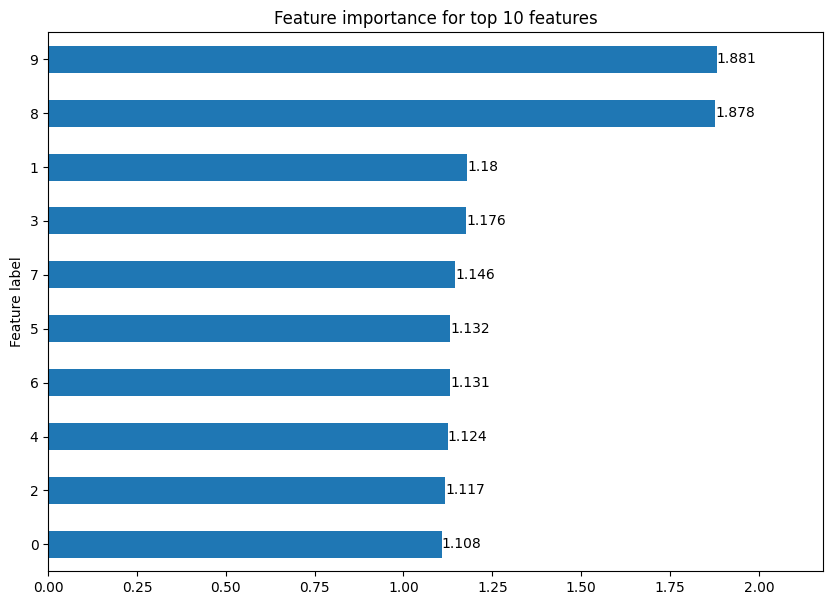

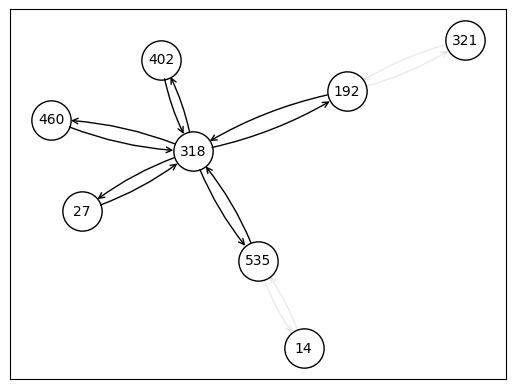

In [109]:
explanation.visualize_feature_importance(top_k=10)

explanation.visualize_graph()

In [29]:
from torch_geometric.explain import unfaithfulness

metric = unfaithfulness(explainer, explanation)
print(metric)

0.1287473440170288


In [30]:
print(type(explanation.edge_mask))
print(explanation.edge_mask.shape)
print(testdata.edge_index.shape)

print(type(explanation.node_mask))
print(explanation.node_mask.shape)
print(testdata.x.shape)

<class 'torch.Tensor'>
torch.Size([387])
torch.Size([2, 387])
<class 'torch.Tensor'>
torch.Size([566, 10])
torch.Size([566, 10])


In [31]:
for i in range(testdata.edge_index.shape[1]):
    edge = testdata.edge_index[:, i]
    if edge[0] == node_to_explain or edge[1] == node_to_explain:
        print(f'Edge connecting to node explained: [{edge[0]}, {edge[1]}] = edge {i}') 

Edge connecting to node explained: [27, 318] = edge 31
Edge connecting to node explained: [192, 318] = edge 233
Edge connecting to node explained: [318, 402] = edge 333
Edge connecting to node explained: [318, 460] = edge 334
Edge connecting to node explained: [318, 535] = edge 335


In [64]:
testdata.edge_index[:,333] = torch.tensor([402,318]).to(device)

# Det är något konstigt. Det verkar som att GNNExplainer inte fattar att
# grafen är undirected. För det spelar roll i vilken ordning noderna är
# i edge_index. Men samtidigt verkar det (enligt https://github.com/pyg-team/pytorch_geometric/issues/1845)
# som att GCNConv antar att grafen är undirected, dvs. inte bryr sig om i vilken ordning noderna är.
# Eller så är det bara en slump att den edges också kommer med i bilden ovan....